In [2]:
%load_ext dotenv
%dotenv

import numpy as np
import networkx as nx
from neo4j import GraphDatabase
import os
import matplotlib.pyplot as plt
import dspy

/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
db_url = os.getenv("DB_HOST", "neo4j://localhost:7687")
db_user = os.getenv("DB_USER", "neo4j")
db_pass = os.getenv("DB_PASSWORD", "no_password")
db_base = os.getenv("DB_DATABASE", "neo4j")
label_model = os.getenv("LABEL_MODEL", "openai/gpt-4o-mini")

export_temp = "/tmp/communities_neo4j_export.graphml"

if not os.path.isfile(export_temp):
	print("Connecting to db")
	with GraphDatabase.driver(db_url, auth=(db_user, db_pass)) as driver:
		driver.verify_connectivity()

		print("Fetching database as graphml")
		records, _, _ = driver.execute_query("""
			CALL apoc.export.graphml.all(null, {stream:true})
			YIELD file, nodes, relationships, properties, data
			RETURN file, nodes, relationships, properties, data
		""")
		_, n_nodes, n_relationships, _, export_contents = records[0]
		print(f"Downloaded {n_nodes} nodes, {n_relationships} relationships")

		print("Saving as temporary file")
		with open(export_temp, "w") as f:
			f.write(export_contents)

print("Loading databse from file")
graph = nx.read_graphml(export_temp)


Loading databse from file


/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id id. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id louv_community. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/graph-rag-testing/.venv/lib/python3.13/site-packages/networkx/readwrite/graphml.py:1034: UserWarning: No key type for id sources. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/saskapult/Desktop/2025intern/

In [4]:
communities = nx.community.louvain_communities(graph)
print(f"Found {len(communities)} communities")

communities.sort(key=lambda v: len(v), reverse=True)

k = 20
print(f"First {k} have populations {[len(c) for c in communities[:k]]}")

Found 1935 communities
First 20 have populations [175, 113, 109, 102, 101, 92, 90, 87, 78, 69, 68, 68, 68, 65, 61, 53, 53, 46, 46, 29]


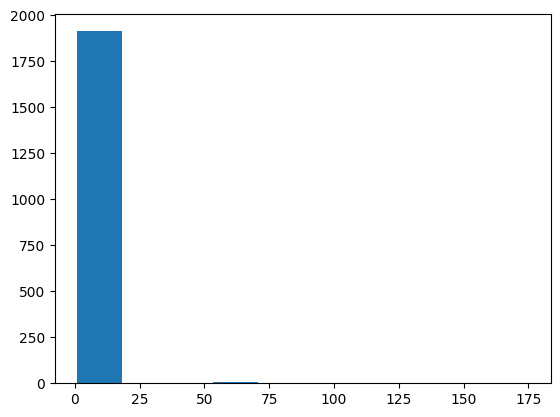

In [5]:
plt.hist([len(c) for c in communities])
plt.show()

# Seems that we get a lot of communities with very few members

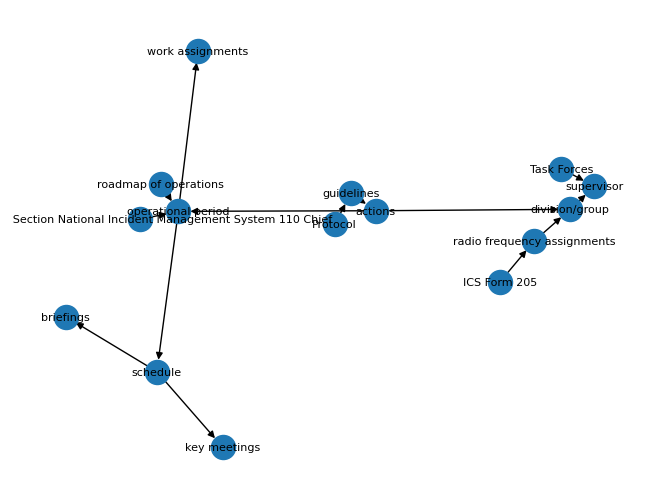

In [6]:
def draw_subgraph(subgraph, **kwargs):
	nx.draw_spring(subgraph, labels=dict(subgraph.nodes(data="id")), font_size=8, **kwargs)

subby = graph.subgraph(communities[22])
draw_subgraph(subby)

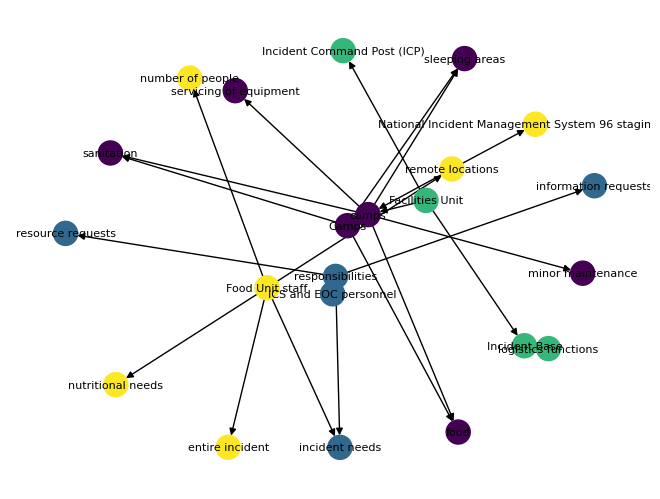

In [7]:
def draw_subgraph_communities(subgraph, communities):
	colours = []
	for node in subgraph:
		i = [i for i, c in enumerate(new_communities) if node in c][0]
		colours.append(i)
	draw_subgraph(subgraph, node_color=colours)

subgraph = graph.subgraph(communities[21])
new_communities = nx.community.louvain_communities(subgraph)

draw_subgraph_communities(subgraph, communities)

In [40]:

lm = dspy.LM(label_model)
dspy.configure(lm=lm)

class CommunityLabelSignature(dspy.Signature):
	"""
	Given a collection of entities, find a few words to label them.
	"""
	entities: list[str] = dspy.InputField()
	# context: str = dspy.InputField() # This bleeds into its answers
	label: str = dspy.OutputField()	

_label_community_p = dspy.Predict(CommunityLabelSignature)

def label_entities(entities):
	return _label_community_p(entities=entities).label

def label_community(graph, community):
	return label_entities([l for n, l in graph.subgraph(community).nodes(data="id")])

def label_community_demo(graph, community):
	entities = [l for n, l in graph.subgraph(community).nodes(data="id")]
	print(f"Graph with contents")
	for e in entities:
		print("\t", e)
	label = label_community(graph, community)
	print(f"is labeled as '{label}'")

label_community_demo(graph, communities[28])

Graph with contents
	 Logistics Section Personnel
	 Cooking Facilities
	 Transportation
	 Food Security and Safety
	 Supplies
	 Facilities
	 Food and Water Needs
	 Incident Traffic Plans
	 Vehicle Usage Records
	 Food Service Areas
	 Ground Transportation
	 Food Services
is labeled as 'Logistics and Food Services'


In [9]:

# Recursively splits communities with at least `threshold` members 
# Retuns list of (this) or node id
def recursive_louvain(graph, threshold=10):
	communities = nx.community.louvain_communities(graph)
	result = []
	for community in communities:
		if len(community) >= threshold:
			# Recurse
			subgraph = graph.subgraph(community)
			result.append(recursive_louvain(subgraph, threshold=threshold))
		else:
			# Terminal community
			result.append(community)
	return result

print(recursive_louvain(graph.subgraph(communities[20]), threshold=5))

[[{'n2700'}, {'n1349'}, {'n3435'}, {'n1979'}, {'n1438'}, {'n3159'}], {'n525', 'n2680', 'n4093'}, [{'n79', 'n2009'}, {'n1112', 'n2221', 'n2619'}], {'n50', 'n240', 'n3269', 'n588'}, [{'n2366', 'n1942'}, {'n1916', 'n1444', 'n1527', 'n1220'}, {'n1992', 'n2021'}]]


In [ ]:

# turn louvain communities into labels 
def recursive_labels(graph, communities):
	if isinstance(communities, list):
		inner = [recursive_labels(graph, c) for c in communities]
		labels, _ = zip(*inner)
		print(f"Make label for {labels}")
		return (label_entities(labels), inner)
	else:
		# Temrinal is a set
		print(f"Make terminal label for {communities}")
		return (label_community(graph, list(communities)), [])

g = recursive_louvain(graph.subgraph(communities[20]), threshold=5)
print(recursive_labels(graph, g))

Make terminal label for {'n2680', 'n525', 'n4093'}
Make terminal label for {'n2700'}
Make terminal label for {'n1349'}
Make terminal label for {'n3435'}
Make terminal label for {'n1979'}
Make terminal label for {'n1438'}
Make terminal label for {'n3159'}
Make label for ('public interest topics', '"Legal Complexity"', '"Technology"', 'Resource Allocation', '"Communication Systems"', 'cause of incident')
Make terminal label for {'n79', 'n2009'}
Make terminal label for {'n1112', 'n2221', 'n2619'}
Make label for ('Data Management', '"Documentation Process"')
Make terminal label for {'n2366', 'n1942'}
Make terminal label for {'n2021', 'n1992'}
Make terminal label for {'n1916', 'n1444', 'n1527', 'n1220'}
Make label for ('Information Management Methods', 'Information Management Concepts', 'Measurement and Planning Tools')
Make terminal label for {'n50', 'n240', 'n3269', 'n588'}
Make label for ('Communication Technologies', '"Interdisciplinary Issues"', 'Data Handling and Documentation', 'Info

0 -> 1
1 -> 2
<class 'set'>
1 -> 3
<class 'set'>
1 -> 4
<class 'set'>
1 -> 5
<class 'set'>
1 -> 6
<class 'set'>
1 -> 7
<class 'set'>
0 -> 8
<class 'set'>
0 -> 9
<class 'set'>
0 -> 10
10 -> 11
<class 'set'>
10 -> 12
<class 'set'>
0 -> 13
13 -> 14
<class 'set'>
13 -> 15
<class 'set'>
13 -> 16
<class 'set'>


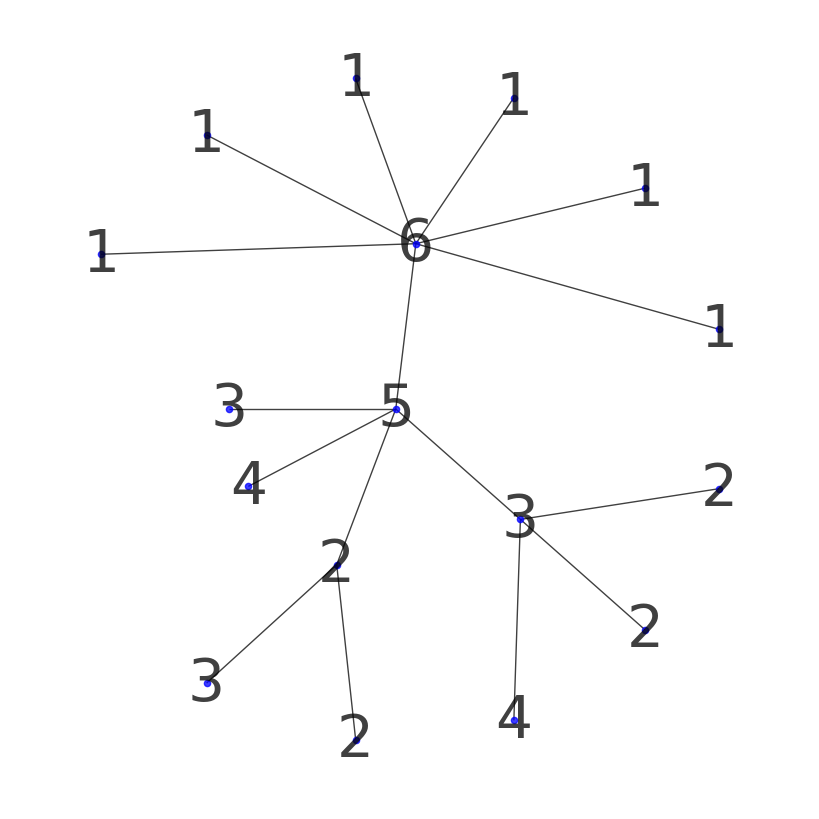

In [ ]:

def communities_labels_graph_recursive(communities):
	g = nx.Graph()

	# Pass-by-reference makes this weird... 
	def dfs_node_addition(graph, communities, parent, labels):
		# Add a node for this community
		i = len(labels)
		graph.add_node(i)
		if i != 0:
			graph.add_edge(parent, i)
			print(f"{parent} -> {i}")
		labels.append((i, f"{len(communities)}"))

		# If it has children, do so for them
		if isinstance(communities, list):
			for community in communities:
				dfs_node_addition(graph, community, i, labels)
		else:
			print(type(communities))
		return labels

	labels = dfs_node_addition(
		g,
		recursive_louvain(graph.subgraph(communities), threshold=5), 
		0,
		[],
	)

	return g, labels

G, labels = communities_labels_graph_recursive(communities[20])

pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_size=20, alpha=0.75, node_color="blue",
	# labels=dict(labels), 
	with_labels=True,
	font_size=42,
)
plt.axis("equal")
plt.show()

In [12]:
len(labels)

321508